In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("PORTFOLIO OPTIMIZATION SYSTEM")
print("="*80)


PORTFOLIO OPTIMIZATION SYSTEM


In [3]:
# Load datasets
instruments = pd.read_csv("../Data/project2_instruments.csv")
trades = pd.read_csv("../Data/project2_trading.csv")

print("\n📊 Instruments loaded:", len(instruments))
print("📊 Trades loaded:", len(trades))



📊 Instruments loaded: 1500
📊 Trades loaded: 30000


In [4]:
# Create returns matrix
trades_enhanced = trades.merge(
    instruments[['instrument_id', 'instrument_name', 'sector', 'beta', 'volatility_30d']], 
    on='instrument_id', 
    how='left'
)

print("\n✅ Data merged successfully")
print("\nInstruments sample:")
print(instruments.head())
print("\nTrades sample:")
print(trades_enhanced.head())



✅ Data merged successfully

Instruments sample:
  instrument_id symbol         instrument_name   asset_class exchange  \
0    INST_00001   EQSU          Superior Group  Fixed Income     NYSE   
1    INST_00002   WYUT      Global Enterprises     Commodity      LSE   
2    INST_00003   ZCLW            Dynamic Corp   Derivatives      TSE   
3    INST_00004   QYNK     Strategic Solutions        Crypto      LSE   
4    INST_00005   YTEP  Superior Manufacturing     Commodity      TSE   

       sector  market_cap_usd  avg_daily_volume      beta  volatility_30d  \
0   Financial    1.151404e+11      2.651141e+07 -0.738669        1.032915   
1  Healthcare    1.621521e+12      3.810619e+06 -1.517421        0.203198   
2      Energy    1.437219e+12      1.458938e+07  2.900766        1.467826   
3      Energy    1.262599e+12      1.804662e+06  0.867632        2.332595   
4   Financial    4.360767e+11      4.480747e+07 -0.910945        2.124709   

   sharpe_ratio  correlation_to_index  dividend_y

In [5]:
# Create returns matrix
returns = trades.pivot_table(
    index="timestamp",
    columns="instrument_id",
    values="pnl_usd"
).pct_change().dropna()

mean_returns = returns.mean()
cov_matrix = returns.cov()
correlation_matrix = returns.corr()

print("\n" + "="*80)
print("PORTFOLIO STATISTICS")
print("="*80)
print(f"\n📈 Number of assets: {len(returns.columns)}")
print(f"📈 Time periods: {len(returns)}")
print(f"📈 Average return range: {mean_returns.min():.4f} to {mean_returns.max():.4f}")
print(f"📈 Volatility range: {returns.std().min():.4f} to {returns.std().max():.4f}")



PORTFOLIO STATISTICS

📈 Number of assets: 1500
📈 Time periods: 18991
📈 Average return range: -0.0854 to 0.6227
📈 Volatility range: 0.0106 to 85.8933


In [6]:
# Portfolio constraints (user can modify these)
CONSTRAINTS_CONFIG = {
    'max_position_weight': 0.15,        # Max 15% per position
    'min_position_weight': 0.0,         # Min 0% (no shorts)
    'gross_exposure': 1.0,              # 100% invested
    'net_exposure_min': 0.95,           # At least 95% net exposure
    'net_exposure_max': 1.0,            # Max 100% net exposure
    'max_turnover': 0.30,               # Max 30% turnover
    'max_tracking_error': 0.05,         # Max 5% tracking error
    'sector_max_weight': 0.35,          # Max 35% per sector
}

print("\n" + "="*80)
print("OPTIMIZATION CONSTRAINTS")
print("="*80)
for key, value in CONSTRAINTS_CONFIG.items():
    print(f"  {key}: {value}")


OPTIMIZATION CONSTRAINTS
  max_position_weight: 0.15
  min_position_weight: 0.0
  gross_exposure: 1.0
  net_exposure_min: 0.95
  net_exposure_max: 1.0
  max_turnover: 0.3
  max_tracking_error: 0.05
  sector_max_weight: 0.35


In [7]:
def portfolio_return(weights, mean_returns):
    """Calculate expected portfolio return"""
    return np.dot(weights, mean_returns)

def portfolio_volatility(weights, cov_matrix):
    """Calculate portfolio volatility"""
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def portfolio_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.02):
    """Calculate Sharpe ratio"""
    ret = portfolio_return(weights, mean_returns)
    vol = portfolio_volatility(weights, cov_matrix)
    return (ret - risk_free_rate) / vol if vol > 0 else 0

def calculate_tracking_error(weights, benchmark_weights, cov_matrix):
    """Calculate tracking error vs benchmark"""
    active_weights = weights - benchmark_weights
    return np.sqrt(np.dot(active_weights.T, np.dot(cov_matrix, active_weights)))

def calculate_var(weights, returns_matrix, confidence=0.95):
    """Calculate Value at Risk"""
    portfolio_returns = returns_matrix.dot(weights)
    return np.percentile(portfolio_returns, (1 - confidence) * 100)

def calculate_expected_shortfall(weights, returns_matrix, confidence=0.95):
    """Calculate Expected Shortfall (CVaR)"""
    portfolio_returns = returns_matrix.dot(weights)
    var = np.percentile(portfolio_returns, (1 - confidence) * 100)
    return portfolio_returns[portfolio_returns <= var].mean()


In [8]:
assets = returns.columns.tolist()
num_assets = len(assets)

# Get current weights (approximate from recent trades)
current_weights = trades.groupby("instrument_id")["portfolio_weight"].mean()
current_weights = current_weights.reindex(assets).fillna(0)
current_weights = current_weights / current_weights.sum() if current_weights.sum() > 0 else current_weights

# Benchmark weights (equal weight or market cap weighted)
benchmark_weights = np.ones(num_assets) / num_assets

# Initial guess (current weights or equal weights)
initial_weights = current_weights.values if current_weights.sum() > 0 else benchmark_weights

# Define bounds
bounds = tuple((CONSTRAINTS_CONFIG['min_position_weight'], 
                CONSTRAINTS_CONFIG['max_position_weight']) for _ in range(num_assets))

# Define constraints
constraints = [
    # Sum to gross exposure
    {'type': 'eq', 'fun': lambda w: np.sum(w) - CONSTRAINTS_CONFIG['gross_exposure']},
    
    # Net exposure bounds
    {'type': 'ineq', 'fun': lambda w: np.sum(w) - CONSTRAINTS_CONFIG['net_exposure_min']},
    {'type': 'ineq', 'fun': lambda w: CONSTRAINTS_CONFIG['net_exposure_max'] - np.sum(w)},
    
    # Turnover constraint
    {'type': 'ineq', 'fun': lambda w: CONSTRAINTS_CONFIG['max_turnover'] - np.sum(np.abs(w - current_weights.values))},
    
    # Tracking error constraint
    {'type': 'ineq', 'fun': lambda w: CONSTRAINTS_CONFIG['max_tracking_error'] - 
                                      calculate_tracking_error(w, benchmark_weights, cov_matrix)},
]

# Add sector constraints
instrument_sector_map = instruments.set_index('instrument_id')['sector'].to_dict()
sectors = instruments['sector'].unique()

for sector in sectors:
    sector_instruments = [i for i, instr_id in enumerate(assets) 
                         if instrument_sector_map.get(instr_id) == sector]
    if len(sector_instruments) > 0:
        constraints.append({
            'type': 'ineq',
            'fun': lambda w, idx=sector_instruments: CONSTRAINTS_CONFIG['sector_max_weight'] - 
                                                     np.sum(w[idx])
        })

print("\n" + "="*80)
print("RUNNING OPTIMIZATION")
print("="*80)

# Objective: Minimize volatility (risk-parity approach)
# Alternative objectives can be: maximize Sharpe, minimize tracking error, etc.

def objective_function(weights):
    """Minimize volatility while maximizing return (risk-adjusted)"""
    ret = portfolio_return(weights, mean_returns)
    vol = portfolio_volatility(weights, cov_matrix)
    # Return negative Sharpe ratio (to minimize)
    return -((ret - 0.02) / vol) if vol > 0 else 1e10

# Run optimization
print("\n⚙️  Optimizing portfolio...")
opt_result = minimize(
    objective_function,
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 1000, 'ftol': 1e-9}
)

if opt_result.success:
    print("✅ Optimization successful!")
    opt_weights = opt_result.x
else:
    print("⚠️  Optimization did not fully converge. Using best available solution.")
    opt_weights = opt_result.x

# Normalize weights to ensure they sum to 1.0
opt_weights = opt_weights / opt_weights.sum()



RUNNING OPTIMIZATION

⚙️  Optimizing portfolio...
⚠️  Optimization did not fully converge. Using best available solution.


In [9]:
# Create mapping of instrument_id to instrument_name
instrument_name_map = instruments.set_index('instrument_id')['instrument_name'].to_dict()

target_weights_df = pd.DataFrame({
    "instrument_id": assets,
    "instrument_name": [instrument_name_map.get(id, f"Unknown_{id}") for id in assets],
    "current_weight": current_weights.values,
    "target_weight": opt_weights,
    "change": opt_weights - current_weights.values
})

# Add sector information
target_weights_df['sector'] = target_weights_df['instrument_id'].map(instrument_sector_map)

# Sort by target weight descending
target_weights_df = target_weights_df.sort_values('target_weight', ascending=False)

target_weights_df.to_csv("target_weights_with_names.csv", index=False)
print("\n💾 Target weights saved: target_weights_with_names.csv")

print("\n📋 Top 10 Target Holdings:")
print(target_weights_df[['instrument_name', 'sector', 'target_weight']].head(10).to_string(index=False))


💾 Target weights saved: target_weights_with_names.csv

📋 Top 10 Target Holdings:
       instrument_name     sector  target_weight
    Advanced Solutions Industrial       0.041863
Advanced Manufacturing Industrial       0.037936
         Premier Group Technology       0.032703
         Advanced Corp Healthcare       0.028527
    Elite Technologies Healthcare       0.025951
     Global Industries     Energy       0.025817
 Dynamic Manufacturing Industrial       0.025135
         Advanced Corp Technology       0.022711
    Innovative Systems Healthcare       0.022345
    Advanced Supply Co Technology       0.022084


In [10]:
trade_recommendations = target_weights_df.copy()
trade_recommendations['action'] = trade_recommendations['change'].apply(
    lambda x: 'BUY' if x > 0.001 else ('SELL' if x < -0.001 else 'HOLD')
)
trade_recommendations['trade_size_pct'] = trade_recommendations['change'].abs() * 100

# Filter for meaningful trades
significant_trades = trade_recommendations[trade_recommendations['action'] != 'HOLD'].copy()
significant_trades = significant_trades.sort_values('trade_size_pct', ascending=False)

trade_recommendations.to_csv("trade_recommendations_with_names.csv", index=False)
print("💾 Trade recommendations saved: trade_recommendations_with_names.csv")

print("\n📋 Significant Trade Recommendations:")
print(significant_trades[['instrument_name', 'action', 'current_weight', 'target_weight', 'trade_size_pct']].head(15).to_string(index=False))


💾 Trade recommendations saved: trade_recommendations_with_names.csv

📋 Significant Trade Recommendations:
       instrument_name action  current_weight  target_weight  trade_size_pct
          Dynamic Corp    BUY       -0.055748   1.745515e-12        5.574821
         Premier Group    BUY       -0.043373   0.000000e+00        4.337316
 Advanced Technologies    BUY       -0.041417   7.659819e-13        4.141674
           Global Corp    BUY       -0.040398   1.939228e-13        4.039808
        Global Systems   SELL        0.042426   2.995692e-03        3.943006
      Dynamic Partners    BUY       -0.039081   0.000000e+00        3.908075
   Innovative Partners    BUY       -0.038632   2.668605e-13        3.863237
     Global Industries    BUY       -0.038392   1.099305e-13        3.839194
  Innovative Solutions   SELL        0.038286   3.685455e-13        3.828581
            Prime Corp    BUY       -0.035927   2.830715e-13        3.592661
    Premier Industries    BUY       -0.035682  

In [11]:
# Calculate metrics for optimized portfolio
expected_return = portfolio_return(opt_weights, mean_returns)
expected_volatility = portfolio_volatility(opt_weights, cov_matrix)
sharpe_ratio = (expected_return - 0.02) / expected_volatility
tracking_error = calculate_tracking_error(opt_weights, benchmark_weights, cov_matrix)
var_95 = calculate_var(opt_weights, returns, confidence=0.95)
expected_shortfall_95 = calculate_expected_shortfall(opt_weights, returns, confidence=0.95)

# Calculate metrics for current portfolio
current_return = portfolio_return(current_weights.values, mean_returns)
current_volatility = portfolio_volatility(current_weights.values, cov_matrix)
current_sharpe = (current_return - 0.02) / current_volatility if current_volatility > 0 else 0

# Risk contribution by asset
risk_contributions = (opt_weights * np.dot(cov_matrix, opt_weights)) / expected_volatility

# Sector allocation
sector_weights = target_weights_df.groupby('sector')['target_weight'].sum()

risk_report = pd.DataFrame({
    'Metric': [
        'Expected Annual Return',
        'Expected Volatility',
        'Sharpe Ratio',
        'Tracking Error',
        'Value at Risk (95%)',
        'Expected Shortfall (95%)',
        'Total Turnover',
        'Number of Holdings',
        'Max Position Size',
        'Gross Exposure',
        'Net Exposure'
    ],
    'Current Portfolio': [
        f"{current_return*100:.2f}%",
        f"{current_volatility*100:.2f}%",
        f"{current_sharpe:.3f}",
        "N/A",
        "N/A",
        "N/A",
        "N/A",
        f"{(current_weights.values > 0.001).sum()}",
        f"{current_weights.max()*100:.2f}%",
        f"{current_weights.sum()*100:.2f}%",
        f"{current_weights.sum()*100:.2f}%"
    ],
    'Optimized Portfolio': [
        f"{expected_return*100:.2f}%",
        f"{expected_volatility*100:.2f}%",
        f"{sharpe_ratio:.3f}",
        f"{tracking_error*100:.2f}%",
        f"{var_95*100:.2f}%",
        f"{expected_shortfall_95*100:.2f}%",
        f"{np.sum(np.abs(opt_weights - current_weights.values))*100:.2f}%",
        f"{(opt_weights > 0.001).sum()}",
        f"{opt_weights.max()*100:.2f}%",
        f"{opt_weights.sum()*100:.2f}%",
        f"{opt_weights.sum()*100:.2f}%"
    ]
})

risk_report.to_csv("portfolio_risk_return_report.csv", index=False)
print("\n💾 Risk/Return report saved: portfolio_risk_return_report.csv")

print("\n" + "="*80)
print("RISK/RETURN ANALYSIS")
print("="*80)
print(risk_report.to_string(index=False))


💾 Risk/Return report saved: portfolio_risk_return_report.csv

RISK/RETURN ANALYSIS
                  Metric Current Portfolio Optimized Portfolio
  Expected Annual Return             0.26%               1.13%
     Expected Volatility            63.38%              63.56%
            Sharpe Ratio            -0.027              -0.014
          Tracking Error               N/A              62.41%
     Value at Risk (95%)               N/A              -0.00%
Expected Shortfall (95%)               N/A              -1.17%
          Total Turnover               N/A            1500.56%
      Number of Holdings               692                 109
       Max Position Size             4.24%               4.19%
          Gross Exposure           -67.13%             100.00%
            Net Exposure           -67.13%             100.00%



GENERATING VISUALIZATIONS

📊 Visualization saved: portfolio_optimization_dashboard.png


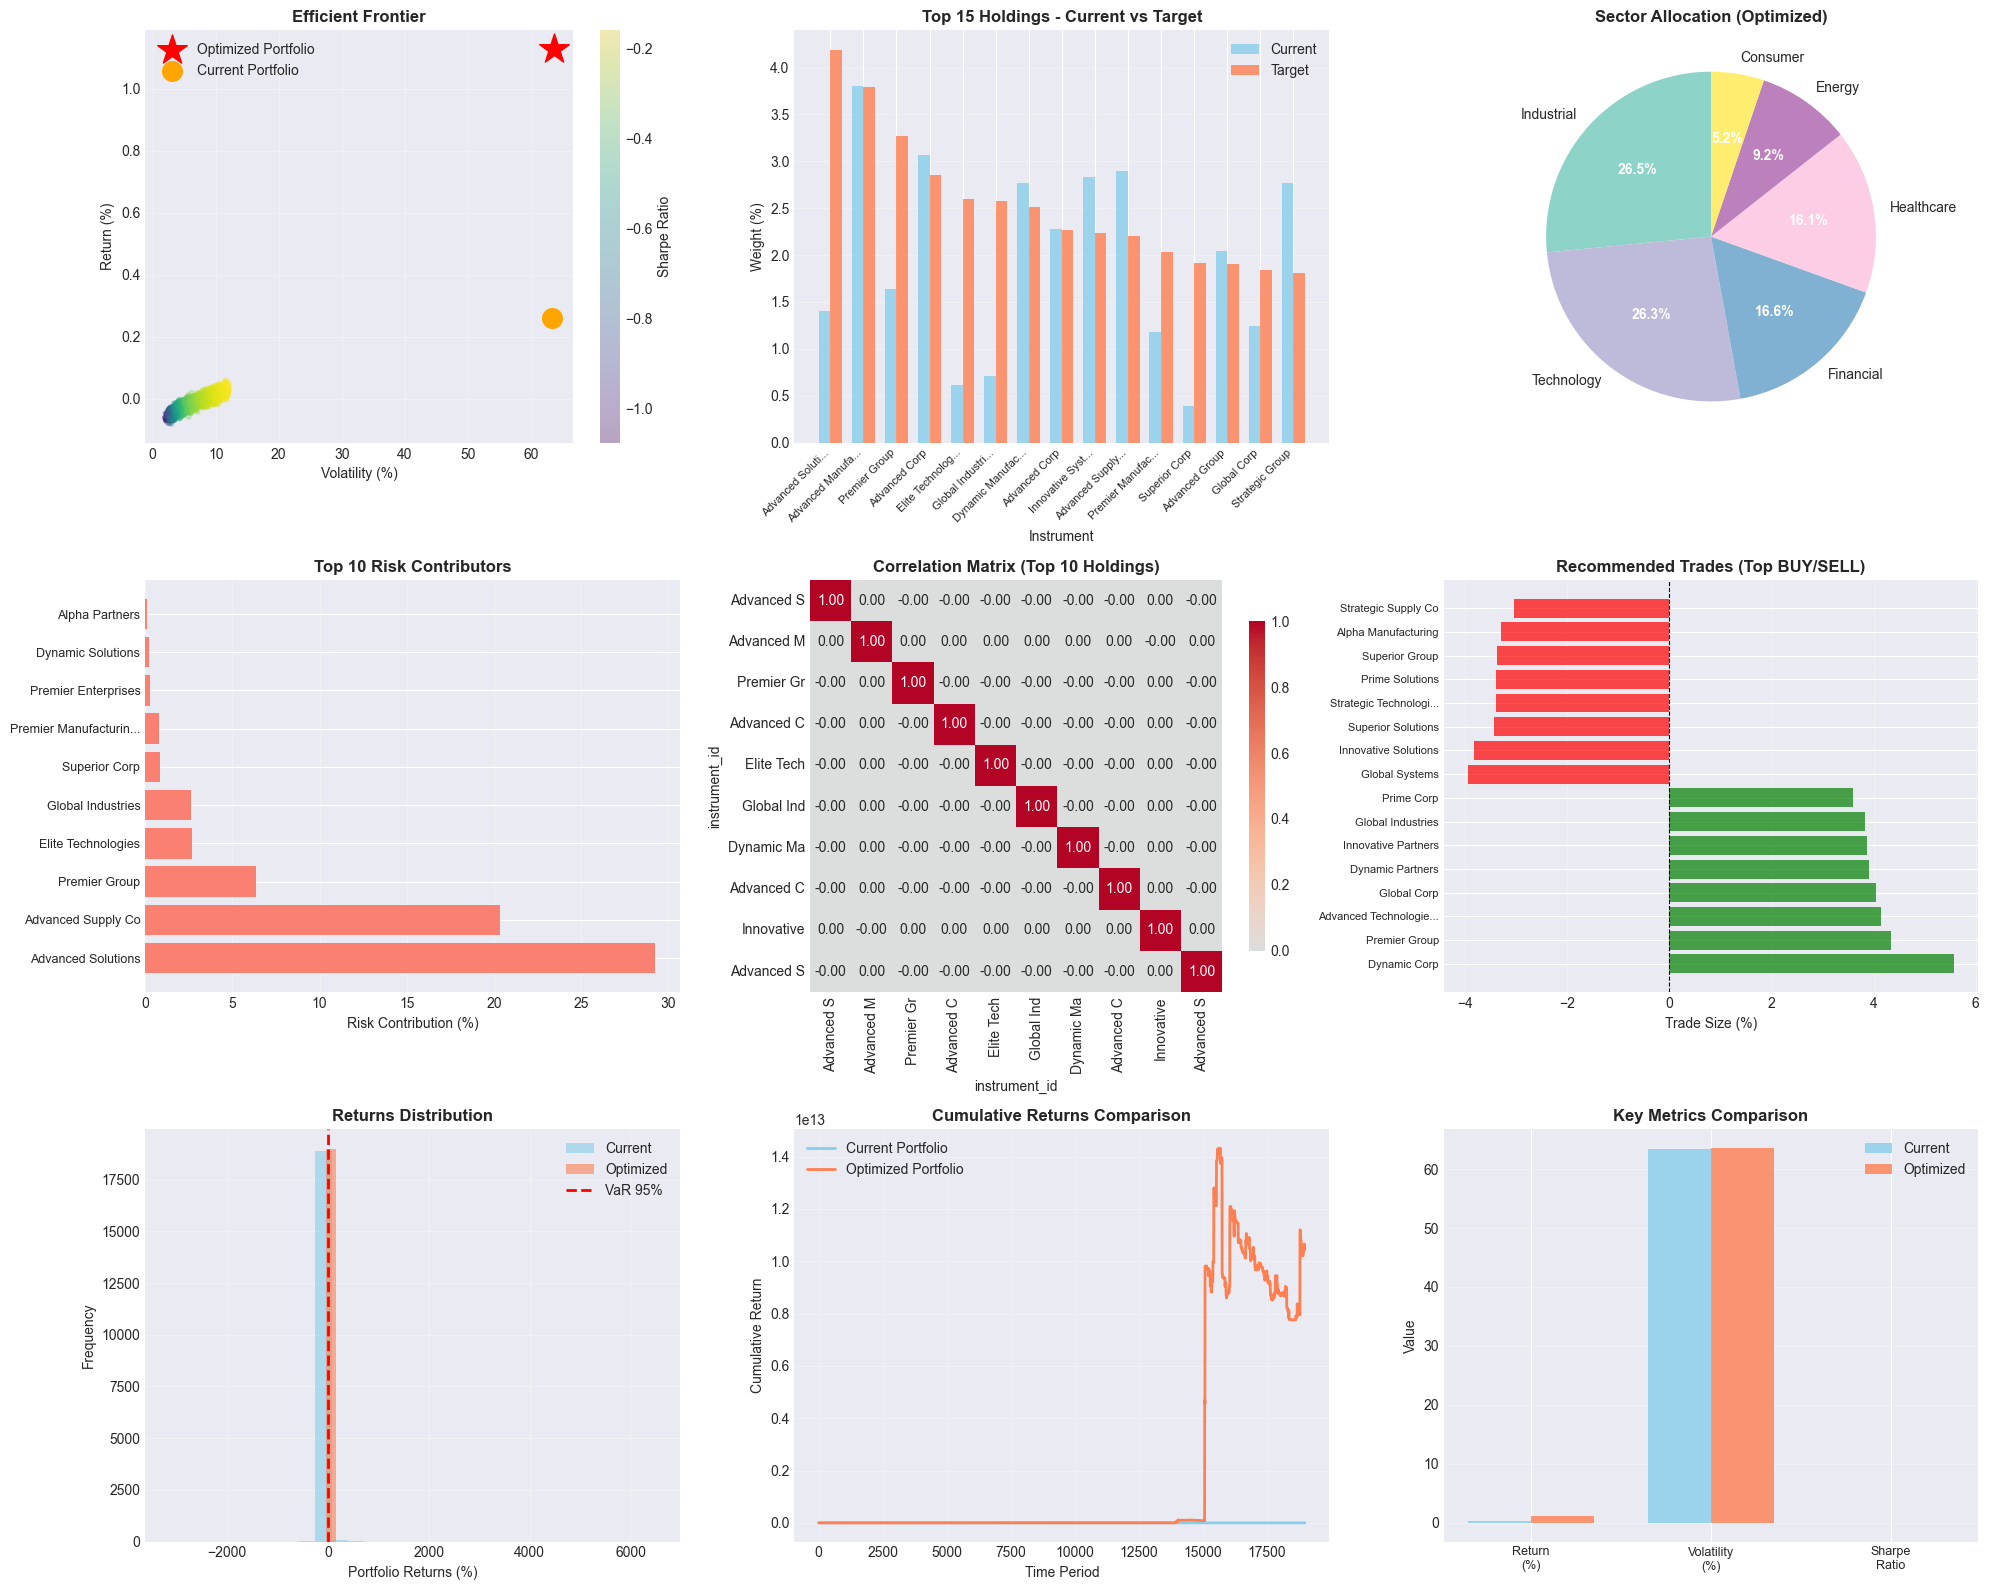

💾 Risk budget report saved: risk_budget_report.csv
💾 Sector allocation report saved: sector_allocation_report.csv

✅ PORTFOLIO OPTIMIZATION COMPLETE

📁 Generated Files:
  1. target_weights_with_names.csv
  2. trade_recommendations_with_names.csv
  3. portfolio_risk_return_report.csv
  4. risk_budget_report.csv
  5. sector_allocation_report.csv
  6. portfolio_optimization_dashboard.png



In [12]:
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(20, 16))

# 1. Efficient Frontier
ax1 = plt.subplot(3, 3, 1)
num_portfolios = 5000
results = np.zeros((3, num_portfolios))
np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    portfolio_return_val = portfolio_return(weights, mean_returns)
    portfolio_volatility_val = portfolio_volatility(weights, cov_matrix)
    sharpe_val = (portfolio_return_val - 0.02) / portfolio_volatility_val
    
    results[0,i] = portfolio_return_val
    results[1,i] = portfolio_volatility_val
    results[2,i] = sharpe_val

scatter = ax1.scatter(results[1,:]*100, results[0,:]*100, c=results[2,:], 
                     cmap='viridis', alpha=0.3, s=10)
ax1.scatter(expected_volatility*100, expected_return*100, 
           marker='*', color='red', s=500, label='Optimized Portfolio', zorder=5)
ax1.scatter(current_volatility*100, current_return*100, 
           marker='o', color='orange', s=200, label='Current Portfolio', zorder=5)
plt.colorbar(scatter, ax=ax1, label='Sharpe Ratio')
ax1.set_xlabel('Volatility (%)', fontsize=10)
ax1.set_ylabel('Return (%)', fontsize=10)
ax1.set_title('Efficient Frontier', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Portfolio Weights Comparison
ax2 = plt.subplot(3, 3, 2)
top_n = 15
top_holdings = target_weights_df.head(top_n)
x = np.arange(len(top_holdings))
width = 0.35

ax2.bar(x - width/2, top_holdings['current_weight']*100, width, 
       label='Current', alpha=0.8, color='skyblue')
ax2.bar(x + width/2, top_holdings['target_weight']*100, width, 
       label='Target', alpha=0.8, color='coral')
ax2.set_xlabel('Instrument', fontsize=10)
ax2.set_ylabel('Weight (%)', fontsize=10)
ax2.set_title(f'Top {top_n} Holdings - Current vs Target', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([name[:15] + '...' if len(name) > 15 else name 
                     for name in top_holdings['instrument_name']], 
                    rotation=45, ha='right', fontsize=8)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. Sector Allocation
ax3 = plt.subplot(3, 3, 3)
sector_allocation = target_weights_df.groupby('sector')['target_weight'].sum().sort_values(ascending=False)
colors = plt.cm.Set3(np.linspace(0, 1, len(sector_allocation)))
wedges, texts, autotexts = ax3.pie(sector_allocation.values, labels=sector_allocation.index, 
                                    autopct='%1.1f%%', colors=colors, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax3.set_title('Sector Allocation (Optimized)', fontsize=12, fontweight='bold')

# 4. Risk Contribution
ax4 = plt.subplot(3, 3, 4)
top_risk = pd.DataFrame({
    'instrument': [instrument_name_map.get(id, f"Unknown_{id}") for id in assets],
    'risk_contribution': risk_contributions
}).sort_values('risk_contribution', ascending=False).head(10)

ax4.barh(range(len(top_risk)), top_risk['risk_contribution']*100, color='salmon')
ax4.set_yticks(range(len(top_risk)))
ax4.set_yticklabels([name[:20] + '...' if len(name) > 20 else name 
                     for name in top_risk['instrument']], fontsize=9)
ax4.set_xlabel('Risk Contribution (%)', fontsize=10)
ax4.set_title('Top 10 Risk Contributors', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# 5. Correlation Heatmap (top holdings)
ax5 = plt.subplot(3, 3, 5)
top_assets = target_weights_df.head(10)['instrument_id'].tolist()
top_corr = correlation_matrix.loc[top_assets, top_assets]
sns.heatmap(top_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
           square=True, ax=ax5, cbar_kws={'shrink': 0.8}, 
           xticklabels=[instrument_name_map.get(id, id)[:10] for id in top_assets],
           yticklabels=[instrument_name_map.get(id, id)[:10] for id in top_assets])
ax5.set_title('Correlation Matrix (Top 10 Holdings)', fontsize=12, fontweight='bold')

# 6. Trade Recommendations
ax6 = plt.subplot(3, 3, 6)
buy_trades = significant_trades[significant_trades['action'] == 'BUY'].head(8)
sell_trades = significant_trades[significant_trades['action'] == 'SELL'].head(8)

y_pos = np.arange(len(buy_trades) + len(sell_trades))
trade_sizes = list(buy_trades['trade_size_pct']) + list(-sell_trades['trade_size_pct'])
trade_names = list(buy_trades['instrument_name']) + list(sell_trades['instrument_name'])
colors = ['green'] * len(buy_trades) + ['red'] * len(sell_trades)

ax6.barh(y_pos, trade_sizes, color=colors, alpha=0.7)
ax6.set_yticks(y_pos)
ax6.set_yticklabels([name[:20] + '...' if len(name) > 20 else name 
                     for name in trade_names], fontsize=8)
ax6.set_xlabel('Trade Size (%)', fontsize=10)
ax6.set_title('Recommended Trades (Top BUY/SELL)', fontsize=12, fontweight='bold')
ax6.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax6.grid(True, alpha=0.3, axis='x')

# 7. Returns Distribution
ax7 = plt.subplot(3, 3, 7)
portfolio_returns_current = returns.dot(current_weights.values)
portfolio_returns_optimized = returns.dot(opt_weights)

ax7.hist(portfolio_returns_current*100, bins=30, alpha=0.6, label='Current', color='skyblue')
ax7.hist(portfolio_returns_optimized*100, bins=30, alpha=0.6, label='Optimized', color='coral')
ax7.axvline(var_95*100, color='red', linestyle='--', linewidth=2, label=f'VaR 95%')
ax7.set_xlabel('Portfolio Returns (%)', fontsize=10)
ax7.set_ylabel('Frequency', fontsize=10)
ax7.set_title('Returns Distribution', fontsize=12, fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Cumulative Returns
ax8 = plt.subplot(3, 3, 8)
cum_returns_current = (1 + portfolio_returns_current).cumprod()
cum_returns_optimized = (1 + portfolio_returns_optimized).cumprod()

ax8.plot(cum_returns_current.values, label='Current Portfolio', linewidth=2, color='skyblue')
ax8.plot(cum_returns_optimized.values, label='Optimized Portfolio', linewidth=2, color='coral')
ax8.set_xlabel('Time Period', fontsize=10)
ax8.set_ylabel('Cumulative Return', fontsize=10)
ax8.set_title('Cumulative Returns Comparison', fontsize=12, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 9. Risk Metrics Comparison
ax9 = plt.subplot(3, 3, 9)
metrics_names = ['Return\n(%)', 'Volatility\n(%)', 'Sharpe\nRatio']
current_metrics = [current_return*100, current_volatility*100, current_sharpe]
optimized_metrics = [expected_return*100, expected_volatility*100, sharpe_ratio]

x = np.arange(len(metrics_names))
width = 0.35

ax9.bar(x - width/2, current_metrics, width, label='Current', alpha=0.8, color='skyblue')
ax9.bar(x + width/2, optimized_metrics, width, label='Optimized', alpha=0.8, color='coral')
ax9.set_ylabel('Value', fontsize=10)
ax9.set_title('Key Metrics Comparison', fontsize=12, fontweight='bold')
ax9.set_xticks(x)
ax9.set_xticklabels(metrics_names, fontsize=9)
ax9.legend()
ax9.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('portfolio_optimization_dashboard.png', dpi=300, bbox_inches='tight')
print("\n📊 Visualization saved: portfolio_optimization_dashboard.png")
plt.show()

# ============================================================================
# 10. ADDITIONAL DETAILED REPORTS
# ============================================================================

# Risk Budget Report
risk_budget_df = pd.DataFrame({
    'instrument_id': assets,
    'instrument_name': [instrument_name_map.get(id, f"Unknown_{id}") for id in assets],
    'weight': opt_weights,
    'risk_contribution': risk_contributions,
    'risk_contribution_pct': risk_contributions / risk_contributions.sum() * 100
}).sort_values('risk_contribution', ascending=False)

risk_budget_df.to_csv("risk_budget_report.csv", index=False)
print("💾 Risk budget report saved: risk_budget_report.csv")

# Sector Risk Report
sector_risk = target_weights_df.groupby('sector').agg({
    'target_weight': 'sum',
    'instrument_id': 'count'
}).rename(columns={'instrument_id': 'num_holdings'})

sector_risk.to_csv("sector_allocation_report.csv")
print("💾 Sector allocation report saved: sector_allocation_report.csv")

print("\n" + "="*80)
print("✅ PORTFOLIO OPTIMIZATION COMPLETE")
print("="*80)
print("\n📁 Generated Files:")
print("  1. target_weights_with_names.csv")
print("  2. trade_recommendations_with_names.csv")
print("  3. portfolio_risk_return_report.csv")
print("  4. risk_budget_report.csv")
print("  5. sector_allocation_report.csv")
print("  6. portfolio_optimization_dashboard.png")
print("\n" + "="*80)